# Task 
Collect the code from https://github.com/gabrielgarza/Mask_RCNN, deploy it in production and add tests to it.

In [1]:
# Import necessary packages
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import unittest

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "Task/coco/"))  # To find local version
from coco import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()

# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Using TensorFlow backend.


... done downloading pretrained model!


## Create Model and Load Trained Weights

In [2]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


### Function to Detect Objects In Image

/Users/lavyfriedman/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


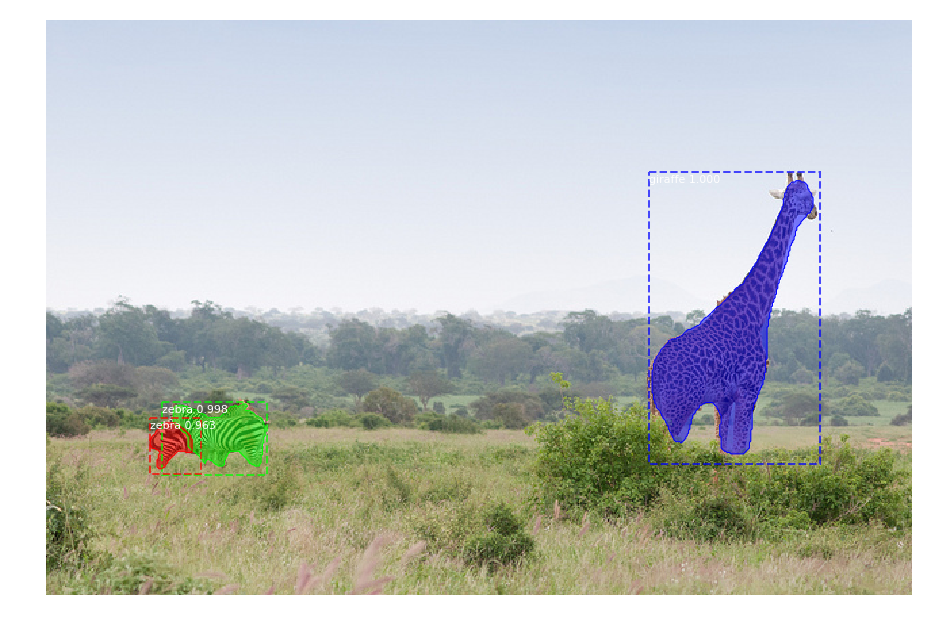

{'rois': array([[112, 445, 328, 572],
        [282,  85, 336, 163],
        [294,  76, 335, 114]], dtype=int32),
 'class_ids': array([24, 23, 23], dtype=int32),
 'scores': array([0.99982977, 0.9981755 , 0.96300715], dtype=float32),
 'masks': array([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        ...,
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
       

In [3]:
# Load log from log file in directory into nested dictionary
results_log = np.load('results_log.npy').item()

def detectObjects(image_filename,save_results=True,show_image=True):
    """
    function to detect objects in images using the model.
    save_results: Save results to log.
    show_image: Show image with annotated ROIs and pixel masks.
    """
    # Load a random image from the images folder
    image   = skimage.io.imread(os.path.join(IMAGE_DIR, image_filename))
    # Run detection
    results = model.detect([image], verbose=0)
    r       = results[0]

    # Visualize results
    if show_image:
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
    #Save results to log file
    if save_results:
        r['Datetime']               = time.strftime("%Y-%m-%d %H:%M")
        results_log[image_filename] = r
        np.save('results_log.npy', results_log)
        
    return r

# Example
detectObjects('6584515005_fce9cec486_z.jpg')

## Unit Testing Class

In [4]:
class TestFunctions(unittest.TestCase):
    def testRunTimeLessThan3Seconds(self):
        """
        Checks that the model runs in less than 3 seconds.
        """
        startTime = time.time()
        # Import image
        image     = skimage.io.imread(os.path.join(IMAGE_DIR, 'testlessThan3.jpg'))
        # Run detection
        model.detect([image], verbose=0)
        
        endTime   = time.time()
        assert endTime-startTime < 3

    def testSmoothedL1Loss(self):
        """
        Checks that the model's smoothed L1 loss fuction works properly.
        """
        #set values (use values to generate diffs both <1 and >1 to test if
        #the smoothed loss works properly)
        y_true           = tf.constant([[0,2,3,2]],dtype=np.float32)
        y_pred           = tf.constant([[-0,-2,2.5,6]],dtype=np.float32)
        
        #Run smoothedL1Loss fuction on the tensors provided
        smoothed_loss    = modellib.smooth_l1_loss(y_true,y_pred)
        expected_loss    = tf.constant([[0,3.5,0.125,3.5]],dtype=np.float32)
        
        #Check that all values in smoothedL1loss tensor are as expected
        with tf.Session() as sess:   t=tf.reduce_all(tf.equal(expected_loss,smoothed_loss)).eval()
        assert t
        
    def testDarkImageNoROIS(self):
        """
        Checks that in a dark image with no objects, the model doesn't "hallucinate" 
        and sees objects that aren't there. 
        """
        #Load image
        image   = skimage.io.imread(os.path.join(IMAGE_DIR, 'darkTest.jpg'))
        # Run detection
        results = model.detect([image], verbose=0)[0]
        n_rois  = results['rois'].shape[0]
        assert n_rois == 0
        
    def testRotatedImageSameDetection(self):
        """
        Checks that if we rotate the image, we still detect the same objects.
        """
        #Load image for test
        image           = skimage.io.imread(os.path.join(IMAGE_DIR, 'rotateTest.jpg'))
        #Rotate image
        rotImage        = np.transpose(image,axes=(1,0,2))
        #Get model's results for both images
        imageResults    = model.detect([image], verbose=0)[0]
        rotImageResults = model.detect([rotImage], verbose=0)[0]
        #Check that the same objects were detected
        assert set(imageResults['class_ids']) == set(rotImageResults['class_ids'])
        #Check that the same number of objects was detected
        assert len(imageResults['class_ids']) == len(rotImageResults['class_ids'])
    
    def testFlippedHorizontalImageSameDetection(self):
        """
        Checks that if we mirror flip the image, we still detect the same objects.
        """
        #Load image for test
        image = skimage.io.imread(os.path.join(IMAGE_DIR, 'flipTest.jpg'))
        #flip image
        flippedHorImage        = np.fliplr(image)
        #Get model's results for both images
        imageResults           = model.detect([image], verbose=0)[0]
        flippedHorImageResults = model.detect([flippedHorImage], verbose=0)[0]
        #Check that the same objects were detected
        assert set(imageResults['class_ids']) == set(flippedHorImageResults['class_ids'])
        #Check that the same number of objects was detected
        assert len(imageResults['class_ids']) == len(flippedHorImageResults['class_ids'])
                
    def testFlippedVerticalImageSameDetection(self):
        """
        Checks that if we vertically flip the image, we still detect the same objects.
        """
        #Load image for test
        image = skimage.io.imread(os.path.join(IMAGE_DIR, 'flipVertTest.jpg'))
        #flip image
        flippedVertImage   = np.flipud(image)
        #Get model's results for both images
        imageResults    = model.detect([image], verbose=0)[0]
        flippedVertImageResults = model.detect([flippedVertImage], verbose=0)[0]
        #Check that the same objects were detected
        assert set(imageResults['class_ids']) == set(flippedVertImageResults['class_ids'])
        #Check that the same number of objects was detected
        assert len(imageResults['class_ids']) == len(flippedVertImageResults['class_ids'])
        
    def testROIAcc(self):
        """
        Checks that the model's ROI IoU with the ground truth ROI is at least 90% on a specific image.
        """
        #Load image for test
        image              = skimage.io.imread(os.path.join(IMAGE_DIR, 'roiAccTest.jpg'))
        
        #Run model on image to get ROI
        imageResults       = model.detect([image], verbose=0)[0]
        modelROI           = imageResults['rois']
        
        #Ground Truth ROI
        groundTruthROI     = np.array([[70,264,415,576],
                           [88,73,397,336]])
        
        #Broadcast ROI arrays for efficiency purposes
        groundTruthROI     = groundTruthROI[:,:,None]
        modelROI           = modelROI[:,:,None]
        
        #Compute area of both ROI
        modelROIArea       = (modelROI[:,2]-modelROI[:,0]) * (modelROI[:,3]-modelROI[:,1])
        groundTruthROIArea = (groundTruthROI[:,2]-groundTruthROI[:,0]) * (groundTruthROI[:,3]-groundTruthROI[:,1])
        
        # Calculate intersections area
        y1 = np.concatenate([groundTruthROI[:,0], modelROI[:,0]],axis=1).max(1)
        x1 = np.concatenate([groundTruthROI[:,1], modelROI[:,1]],axis=1).max(1)
        y2 = np.concatenate([groundTruthROI[:,2], modelROI[:,2]],axis=1).min(1)
        x2 = np.concatenate([groundTruthROI[:,3], modelROI[:,3]],axis=1).min(1)  
        intersectionArea   = ((x2-x1) * (y2-y1))[:,None]
        
        #Compute area of union (inclusion–exclusion principle)
        unionArea =  modelROIArea + groundTruthROIArea - intersectionArea

        iou = intersectionArea / unionArea
        
        #Demand IoU >90% for every object detected 
        assert min(iou) >=0.9
        

#This line runs all the tests in the TestFunctions class
unittest.main(argv=[''],verbosity=1,exit=False)

/Users/lavyfriedman/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
.FF.F..
FAIL: testFlippedHorizontalImageSameDetection (__main__.TestFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-4-b6dd5e8c5574>", line 72, in testFlippedHorizontalImageSameDetection
    assert set(imageResults['class_ids']) == set(flippedHorImageResults['class_ids'])
AssertionError

FAIL: testFlippedVerticalImageSameDetection (__main__.TestFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-4-b6dd5e8c5574>", line 88, in testFlippedVerticalImageSameDetection
    assert set(imageResults['class_ids']) == set(flippedVertImageRes

## Failed Tests

### Rotated Image Test

/Users/lavyfriedman/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


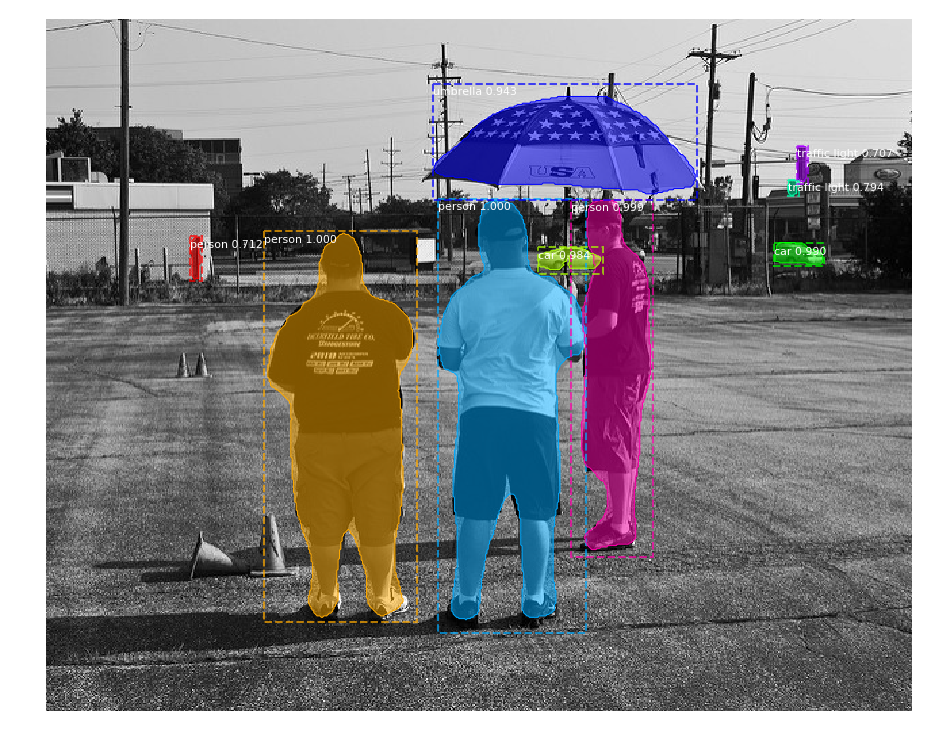

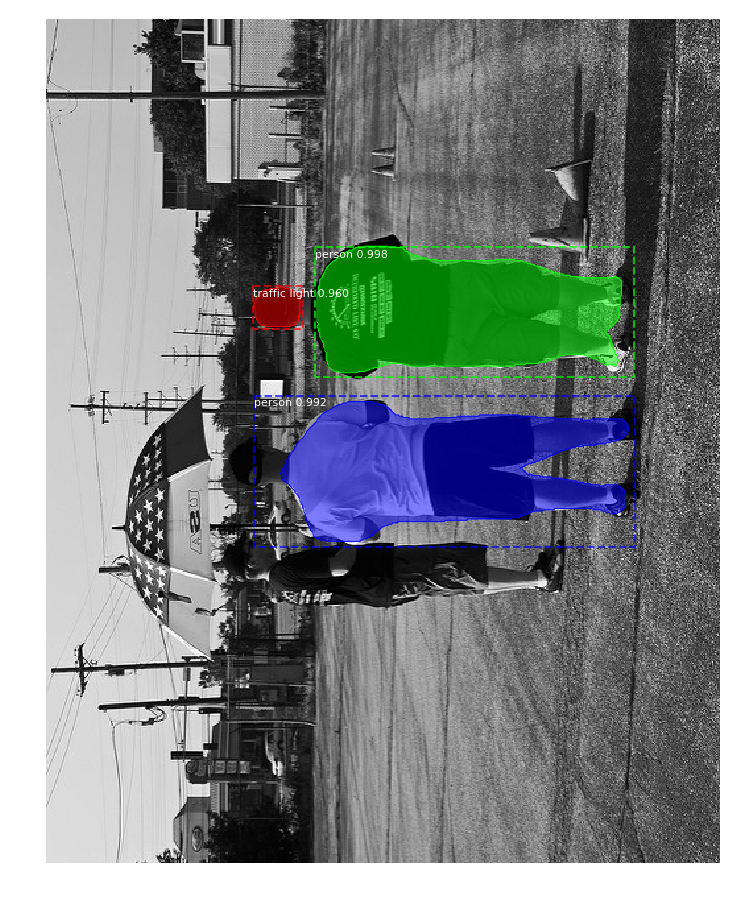

In [5]:
#Load image for test
image           = skimage.io.imread(os.path.join(IMAGE_DIR, 'rotateTest.jpg'))
#Rotate image
rotImage        = np.transpose(image,axes=(1,0,2))
#Get model's results for both images
imageResults    = model.detect([image], verbose=0)[0]
visualize.display_instances(image, imageResults['rois'], imageResults['masks'], imageResults['class_ids'], 
                                    class_names, imageResults['scores'])
rotImageResults = model.detect([rotImage], verbose=0)[0]
visualize.display_instances(rotImage, rotImageResults['rois'], rotImageResults['masks'], rotImageResults['class_ids'], 
                                    class_names, rotImageResults['scores'])

### Horizontal Flip Test

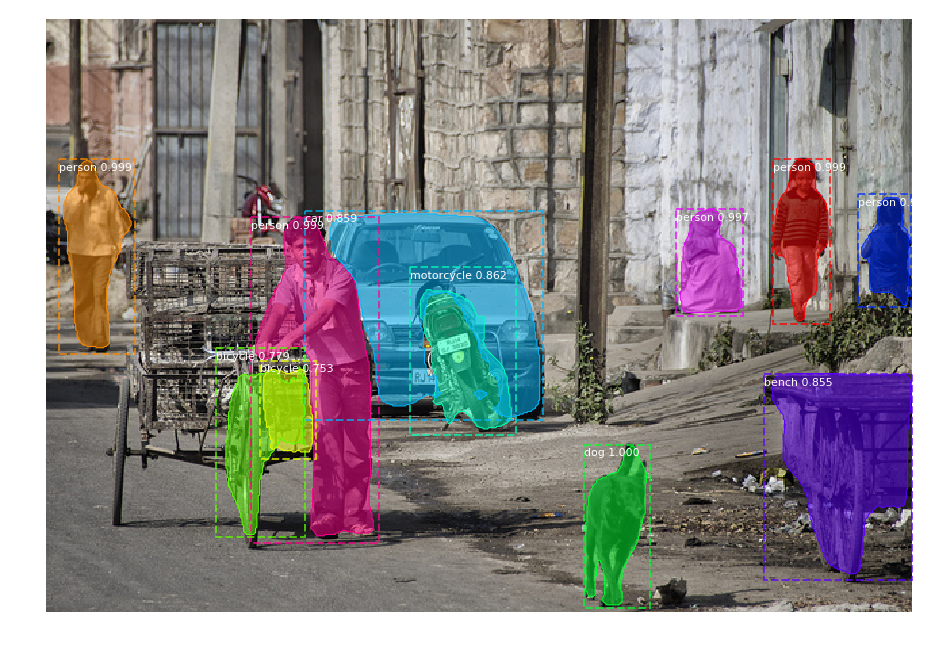

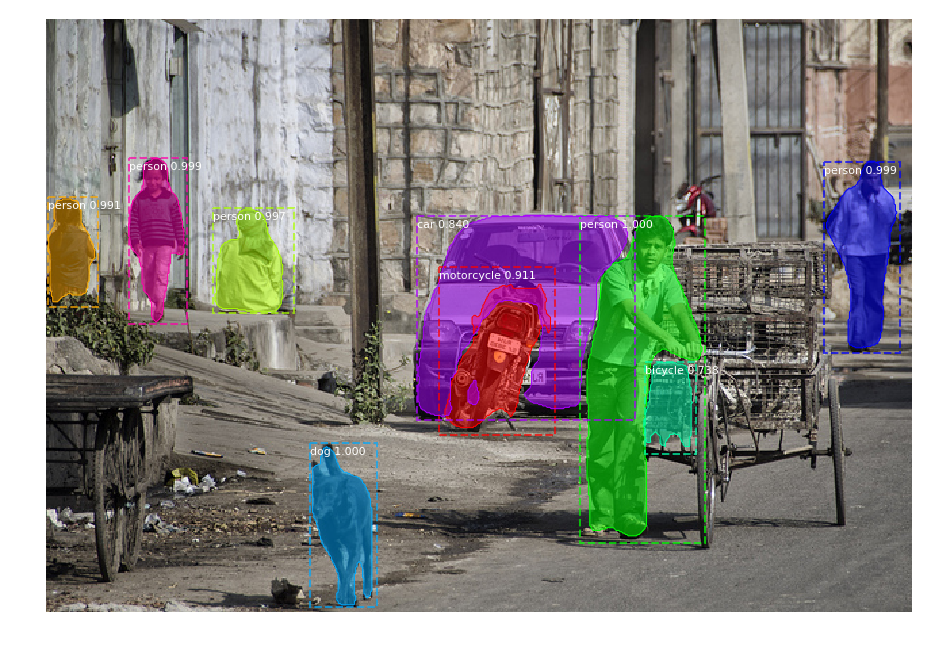

In [6]:
#Load image for test
image             = skimage.io.imread(os.path.join(IMAGE_DIR, 'flipTest.jpg'))
#flip image
flippedHorizImage = np.fliplr(image)
#Get model's results for both images
imageResults      = model.detect([image], verbose=0)[0]
visualize.display_instances(image, imageResults['rois'], imageResults['masks'], imageResults['class_ids'], 
                                    class_names, imageResults['scores'])
flippedHorizImageResults  = model.detect([flippedHorizImage], verbose=0)[0]
visualize.display_instances(flippedHorizImage, flippedHorizImageResults['rois'],flippedHorizImageResults['masks'], flippedHorizImageResults['class_ids'], 
                                    class_names, flippedHorizImageResults['scores'])

### Vertical Flip Test

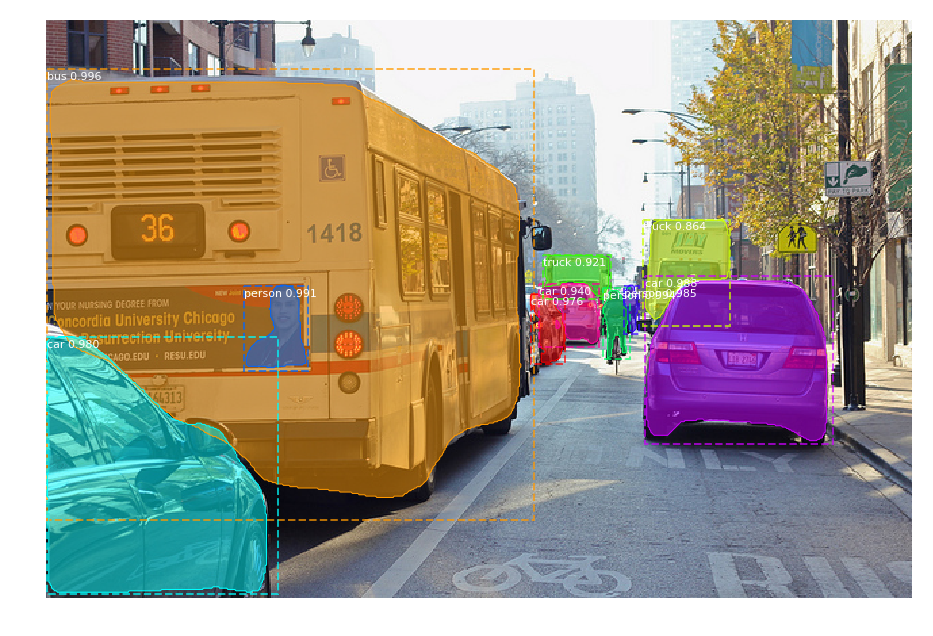

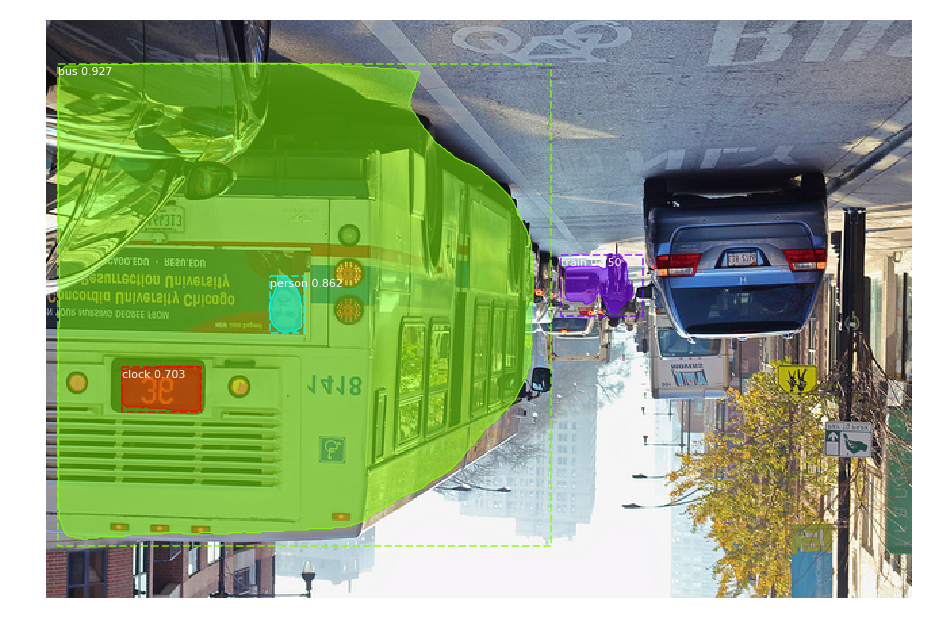

In [7]:
#Load image for test
image            = skimage.io.imread(os.path.join(IMAGE_DIR, 'flipVertTest.jpg'))
#flip image
flippedVertImage = np.flipud(image)
#Get model's results for both images
imageResults     = model.detect([image], verbose=0)[0]
visualize.display_instances(image, imageResults['rois'], imageResults['masks'], imageResults['class_ids'], 
                                    class_names, imageResults['scores'])
flippedVertImageResults  = model.detect([flippedVertImage], verbose=0)[0]
visualize.display_instances(flippedVertImage, flippedVertImageResults['rois'],flippedVertImageResults['masks'], flippedVertImageResults['class_ids'], 
                                    class_names, flippedVertImageResults['scores'])